In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.tree import plot_tree

Prepare data

In [2]:
df = pd.read_csv('data/DatasetEV3.csv')
df = df[df['100% representative'] == 1]
df.dropna(subset=['energy', 'carboxysome', 'Rate mean [s-1]'], inplace=True)

# Encode categorical variables as numeric
df['phototrophy'] = df['energy'].map({'photo': 1, 'chemo': 0})
df['α-cyanobacteria'] = df['Form'].apply(lambda x: 1 if x == 'IAc_cyano' else 0)
df['β-cyanobacteria'] = df['Form'].apply(lambda x: 1 if x == 'IB' else 0)
df['CCM-proteobacteria'] = df['Form'].apply(lambda x: 1 if x == 'IAc_noncyano' else 0)

Random forests

In [3]:
feature_names = ['phototrophy', 'carboxysome', 'α-cyanobacteria', 'β-cyanobacteria', 'CCM-proteobacteria']
X = df[feature_names].copy()
y = df['Rate mean [s-1]']

rfr_model = RandomForestRegressor(max_depth=3, random_state=42)

shap_values_list = []
rmse_values = []
explained_variance_values = []
rfr_model_list = [None] * 100  #  list to store models

for i in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=i)
    rfr_model.fit(X_train, y_train)
    rfr_model_list[i] = rfr_model  # Store the trained model
    
    y_pred = rfr_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)
     
    evs = explained_variance_score(y_test, y_pred)
    explained_variance_values.append(evs)
    
    rfr_explainer = shap.TreeExplainer(rfr_model)
    rfr_shap_values = rfr_explainer.shap_values(X_test)
    shap_values_list.append(np.mean(np.abs(rfr_shap_values), axis=0))
    
shap_values_df = pd.DataFrame(data=shap_values_list, columns=feature_names)
avg_rmse = np.mean(rmse_values)
avg_evs = np.mean(explained_variance_values)

print("Average RMSE:", avg_rmse)
print("Average Explained Variance Score:", avg_evs)


  0%|          | 0/100 [00:00<?, ?it/s]

Average RMSE: 2.084619347073419
Average Explained Variance Score: 0.5608540551502998


Visualize 3 trees

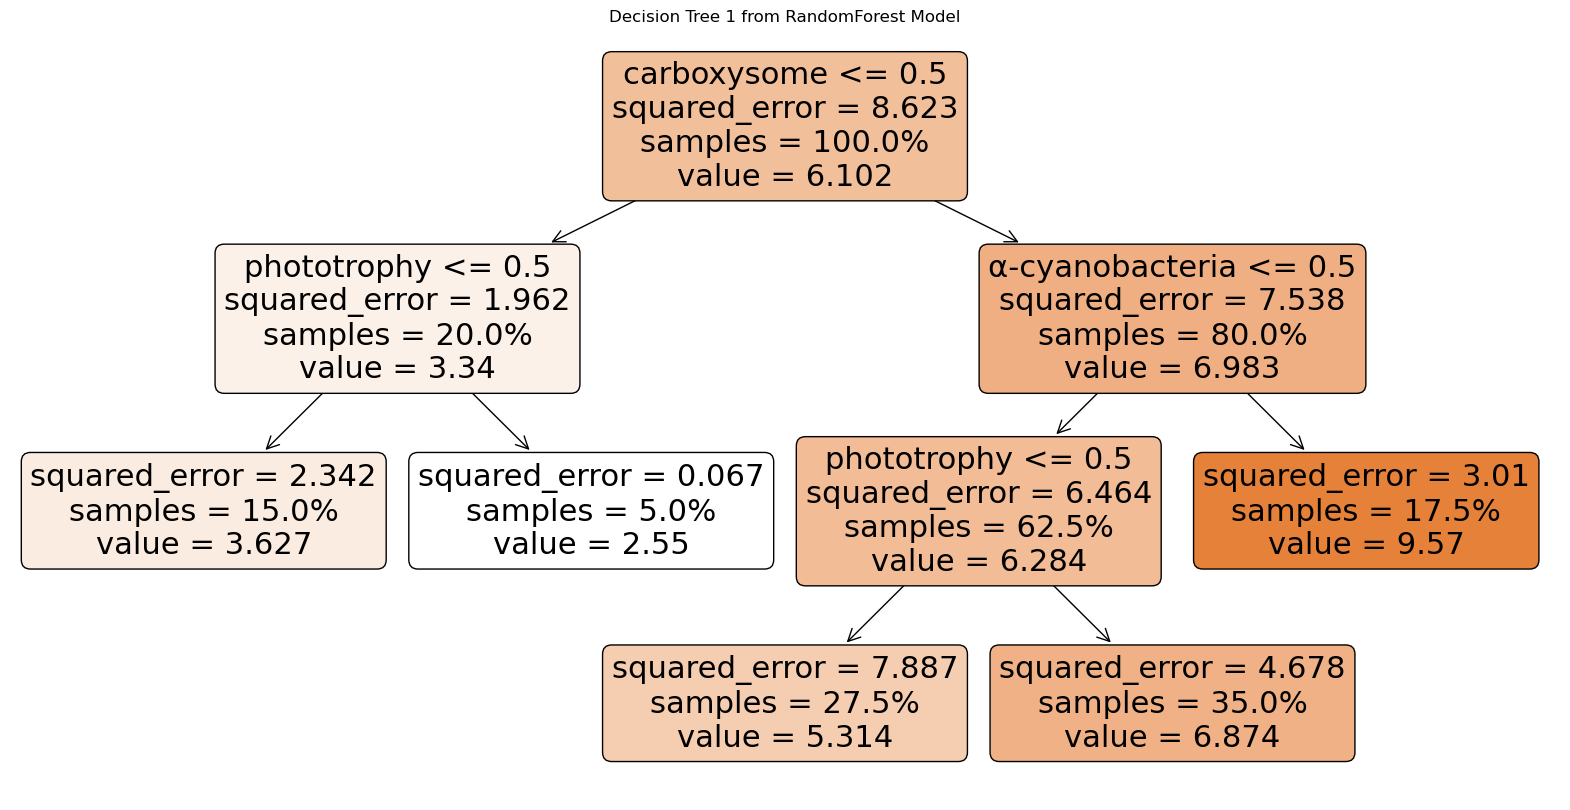

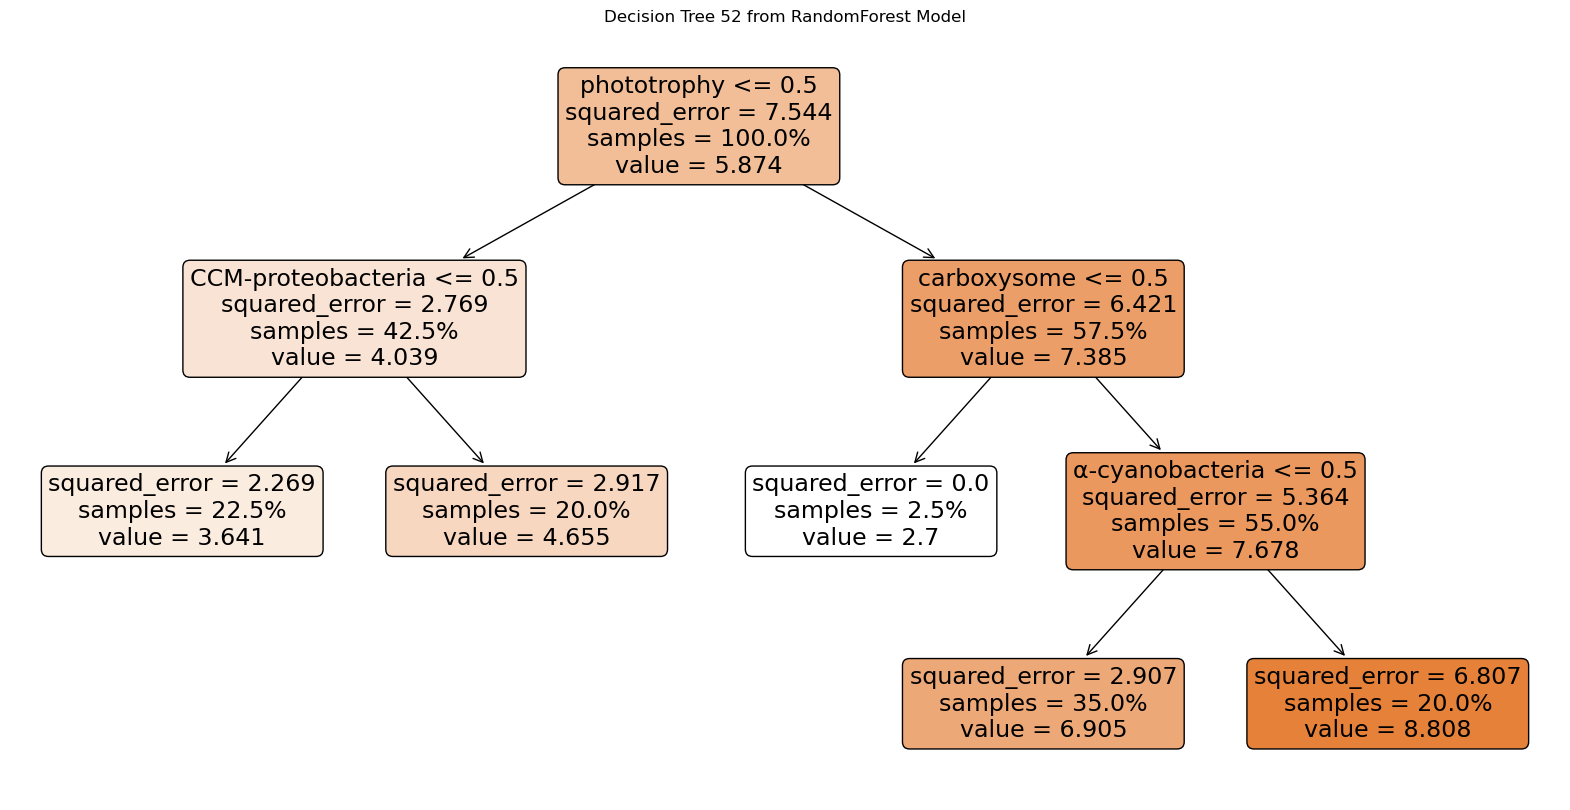

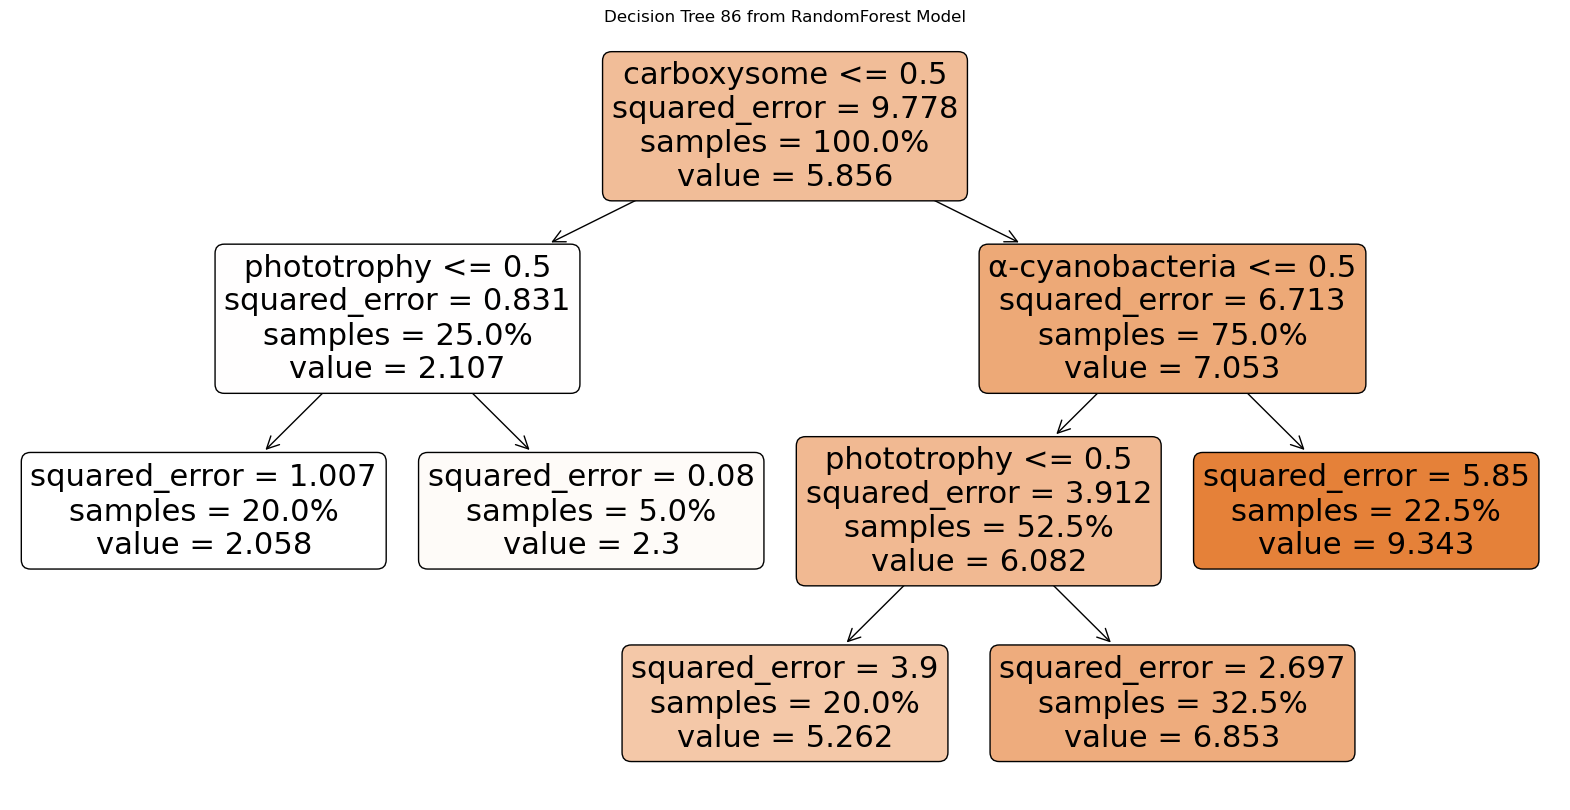

In [8]:
#tree_indices = [49, 75, 99]
#tree_indices = [50, 51, 52]
#tree_indices = [51, 72, 90]
#tree_indices = [51, 53, 54]
#tree_indices = [51, 55, 56]
tree_indices = [0, 51, 85]
#tree_indices = range(100)

for idx in tree_indices:
    tree = rfr_model.estimators_[idx]  # Get the tree from the ensemble

    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=feature_names, filled=True, rounded=True, proportion=True)
    plt.title(f"Decision Tree {idx + 1} from RandomForest Model")
    plt.show()

Plot the prediction

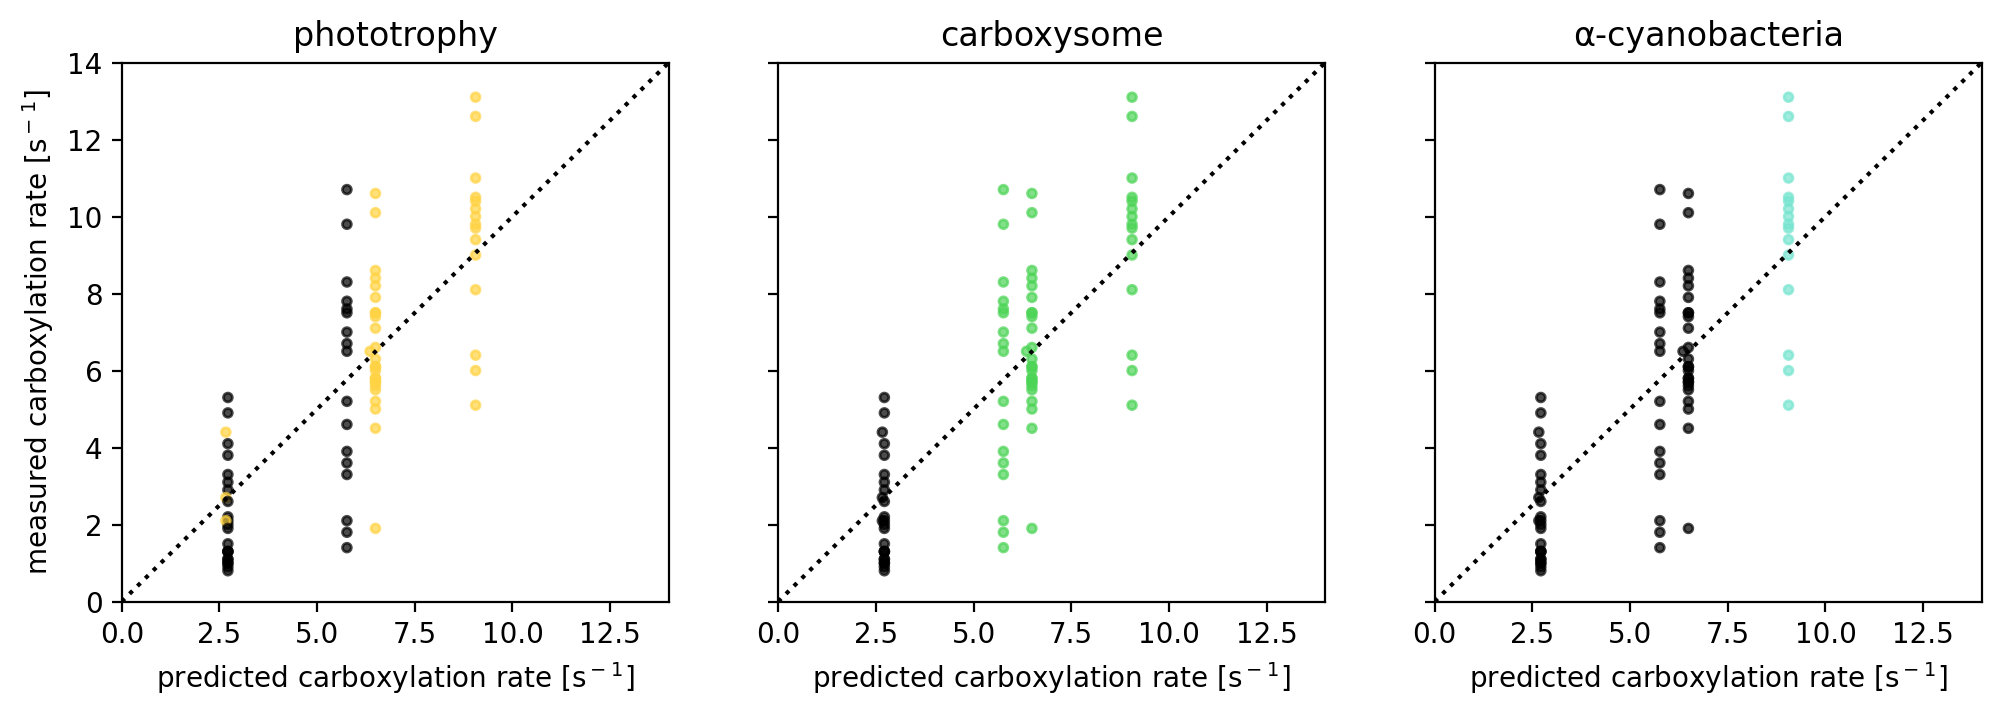

In [9]:
# Plot scatter plots for the first three parameters
predictions = rfr_model.predict(X)
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), dpi=200, sharex=True, sharey=True)
fig.patch.set_facecolor('none')

colors_list = [
    ['#ffd343ff' if val == 1 else 'black' for val in X.iloc[:, 0]],   
    ['#4cd456ff' if val == 1 else 'black' for val in X.iloc[:, 1]],    
    ['#76e5d0ff' if val == 1 else 'black' for val in X.iloc[:, 2]]   
]

for i, ax in enumerate(axs.flat):
    ax.scatter(predictions, y, c=colors_list[i], s=10, alpha=.7)
    ax.plot([0, 14], [0, 14], "k:")
    ax.set_xlabel('predicted carboxylation rate [s$^-$$^1$]')
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 14)
    ax.set_title(X.columns[i])


axs[0].set_ylabel('measured carboxylation rate [s$^-$$^1$]')
fig.savefig('plots/random_forest.svg', dpi=300, bbox_inches='tight', transparent=True)


Plot SHAP values

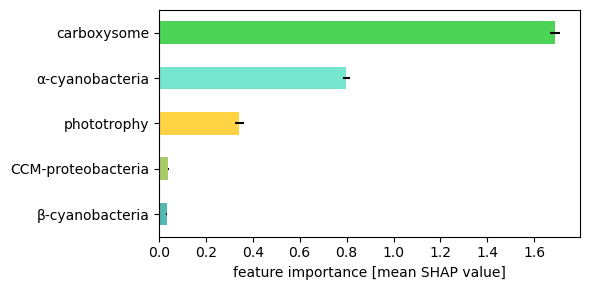

In [6]:
shap_means = shap_values_df.mean()
shap_stds = shap_values_df.std()

# Sorting
sorted_indices = shap_means.argsort()
shap_means_sorted = shap_means.iloc[sorted_indices]
shap_stds_sorted = shap_stds.iloc[sorted_indices]


# Define dict with colors
color_map = {
    "α-cyanobacteria":'#76e5d0ff', 
    "β-cyanobacteria": '#55b9b1ff', 
    "CCM-proteobacteria":'#aacc68ff',
    "carboxysome": "#4cd456ff",
    "phototrophy": "#ffd343ff"
}
colors = [color_map[feature] for feature in shap_means_sorted.index if feature in color_map]



fig, ax = plt.subplots(figsize=(6, 3))
ax.set_facecolor('none')
shap_means_sorted.plot(kind='barh', color=colors, xerr=shap_stds_sorted / np.sqrt(100), ax=ax)
plt.xlabel("feature importance [mean SHAP value]")
plt.tight_layout()
plt.savefig('plots/randomforest_SHAP_importance.pdf', dpi=300, transparent=True)
plt.show()
